# Project Title : Retail Sales Prediction
Sales operates over 3,000 drug stores in 7 European countries. Currently, Sales store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

You are provided with historical sales data for 1,115 Sales stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
# Data Description
Sales Stores Data.csv - historical data including Sales

store.csv - supplemental information about the stores

# Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are - closed on state holidays. Note that all schools are closed on public holidays and - - weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# **1.Loading Important Libraries**




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import missingno as msno
import matplotlib
import matplotlib.pylab as pylab

%matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 8,6

import math
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LassoLars
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet

import warnings
warnings.filterwarnings('ignore')



# **2.   Load Data Set**




In [3]:
sales_data = pd.read_csv('/content/drive/MyDrive/3_Machine_Learning/Project/DS Project (May)/Salesdata.csv')
sales_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31-07-2015,5263,555,1,1,0,1
1,2,5,31-07-2015,6064,625,1,1,0,1
2,3,5,31-07-2015,8314,821,1,1,0,1
3,4,5,31-07-2015,13995,1498,1,1,0,1
4,5,5,31-07-2015,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,01-01-2013,0,0,0,0,a,1
1017205,1112,2,01-01-2013,0,0,0,0,a,1
1017206,1113,2,01-01-2013,0,0,0,0,a,1
1017207,1114,2,01-01-2013,0,0,0,0,a,1


In [4]:
store_data = pd.read_csv('/content/drive/MyDrive/3_Machine_Learning/Project/DS Project (May)/store.csv')
store_data

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# Analysing Sales Dataset

In [5]:
sales_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31-07-2015,5263,555,1,1,0,1
1,2,5,31-07-2015,6064,625,1,1,0,1
2,3,5,31-07-2015,8314,821,1,1,0,1
3,4,5,31-07-2015,13995,1498,1,1,0,1
4,5,5,31-07-2015,4822,559,1,1,0,1


In [6]:
sales_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [7]:
sales_data.rename(columns={'DayOfWeek':'Day_Of_Week','StateHoliday':'State_Holiday','SchoolHoliday':'School_Holiday'},inplace=True)
sales_data.columns

Index(['Store', 'Day_Of_Week', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'State_Holiday', 'School_Holiday'],
      dtype='object')

In [8]:
print("The Numbers Of Rows (observation) is", sales_data.shape[0],'\n',
      "The Numbers Of Columns (variables) is", sales_data.shape[1])

The Numbers Of Rows (observation) is 1017209 
 The Numbers Of Columns (variables) is 9


Checking Information about Dataset

In [9]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Store           1017209 non-null  int64 
 1   Day_Of_Week     1017209 non-null  int64 
 2   Date            1017209 non-null  object
 3   Sales           1017209 non-null  int64 
 4   Customers       1017209 non-null  int64 
 5   Open            1017209 non-null  int64 
 6   Promo           1017209 non-null  int64 
 7   State_Holiday   1017209 non-null  object
 8   School_Holiday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


**Observation **

* The Date column is in string format and needs conversion to datetime.
* The State_Holiday column has mixed types.

In [10]:
sales_data.describe()

,Store,Day_Of_Week,Sales,Customers,Open,Promo,School_Holiday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [11]:
#Checking Null Values Sales_data
sales_data.isnull().sum()

Store             0
Day_Of_Week       0
Date              0
Sales             0
Customers         0
Open              0
Promo             0
State_Holiday     0
School_Holiday    0
dtype: int64

# Data Preprocessing:

In [12]:
#Convert Date to datetime format
sales_data['Date']=pd.to_datetime(sales_data['Date'])

In [13]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Store           1017209 non-null  int64         
 1   Day_Of_Week     1017209 non-null  int64         
 2   Date            1017209 non-null  datetime64[ns]
 3   Sales           1017209 non-null  int64         
 4   Customers       1017209 non-null  int64         
 5   Open            1017209 non-null  int64         
 6   Promo           1017209 non-null  int64         
 7   State_Holiday   1017209 non-null  object        
 8   School_Holiday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [14]:
print(sales_data['Date'].min(),'initial')
print(sales_data['Date'].max(),'final')

2013-01-01 00:00:00 initial
2015-07-31 00:00:00 final


almost 3 year data

In [15]:
# extract year, month, day and week of year from "Date"

sales_data['Date']=pd.to_datetime(sales_data['Date'])
sales_data['Year'] = sales_data['Date'].apply(lambda x: x.year)
sales_data['Month'] = sales_data['Date'].apply(lambda x: x.month)
sales_data['Day'] = sales_data['Date'].apply(lambda x: x.day)
sales_data['Week_Of_Year'] = sales_data['Date'].apply(lambda x: x.weekofyear)

In [16]:
sales_data.head(2)

,Store,Day_Of_Week,Date,Sales,Customers,Open,Promo,State_Holiday,School_Holiday,Year,Month,Day,Week_Of_Year
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31


In [17]:
sales_data.sort_values(by=['Date','Store'],inplace=True,ascending=[False,True])
sales_data.head(2)

,Store,Day_Of_Week,Date,Sales,Customers,Open,Promo,State_Holiday,School_Holiday,Year,Month,Day,Week_Of_Year
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7,31,31


In [18]:
sales_data.State_Holiday.value_counts()

State_Holiday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [19]:
# Convert all values to strings
sales_data['State_Holiday'] = sales_data['State_Holiday'].astype(str)

In [20]:
sales_data.State_Holiday.value_counts()

State_Holiday
0    986159
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
label_encoder = LabelEncoder()
sales_data['State_Holiday'] = label_encoder.fit_transform(sales_data['State_Holiday'])

In [23]:
sales_data.State_Holiday.value_counts()

State_Holiday
0    986159
1     20260
2      6690
3      4100
Name: count, dtype: int64

# Exploratory Data Analysis (EDA), sales_data

<Axes: >

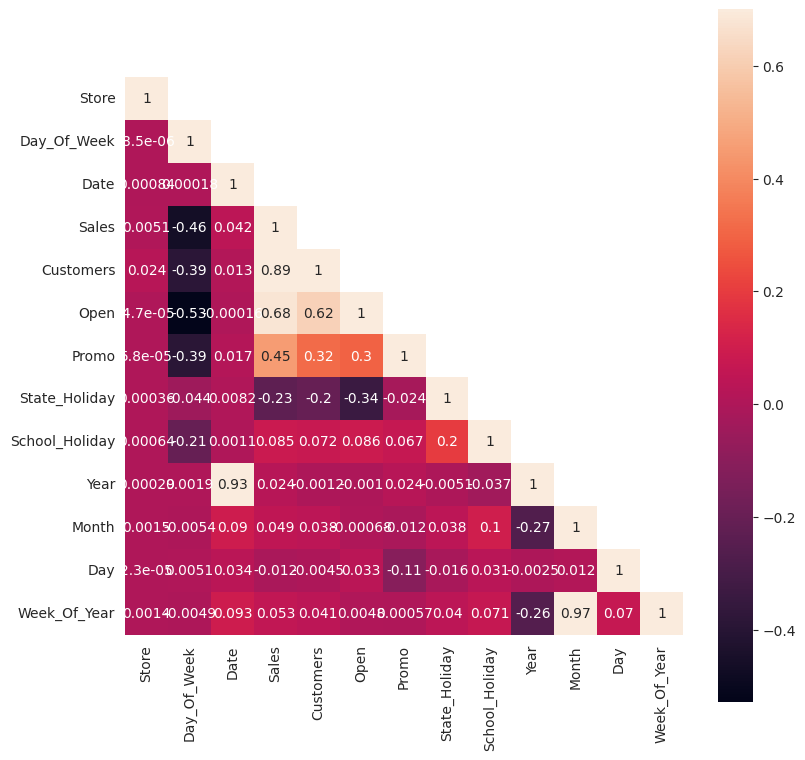

In [24]:
correlation_map = sales_data[sales_data.columns].corr()
obj = np.array(correlation_map)
obj[np.tril_indices_from(obj)] = False
fig,ax= plt.subplots()
fig.set_size_inches(9,9)
sns.heatmap(correlation_map, mask=obj,vmax=.7, square=True,annot=True)

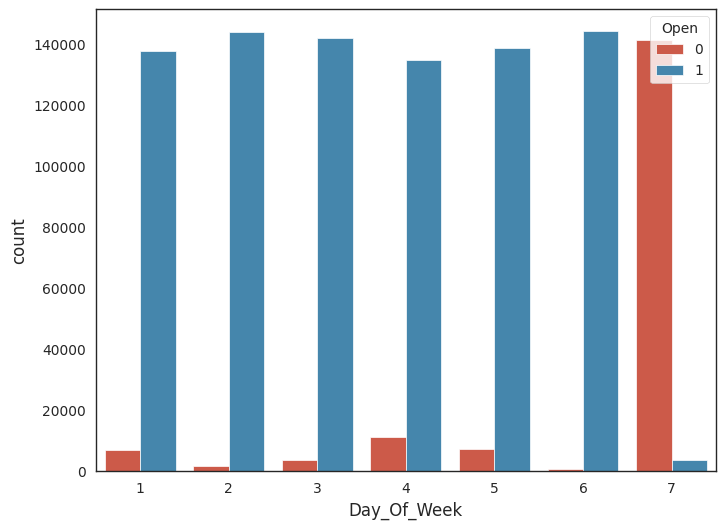

In [25]:
sns.countplot(x='Day_Of_Week',hue='Open',data=sales_data)
plt.show()

As we can see that in the graph given below that Stores mainly closed on Sunday

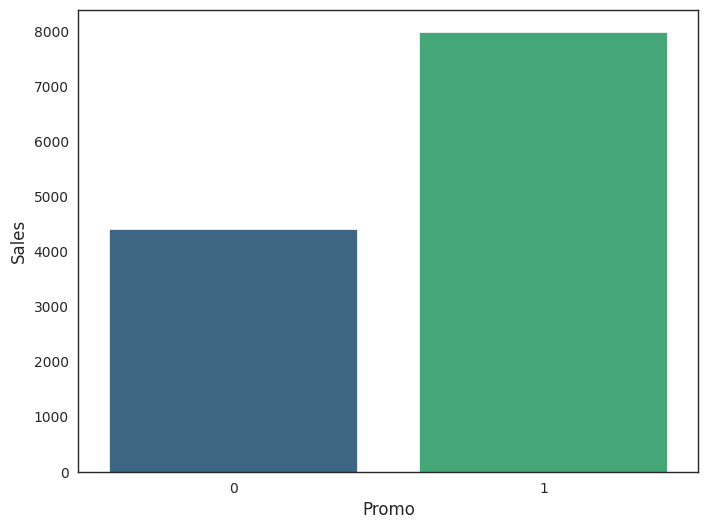

In [26]:
#Impact of promo on sales
Promo_sales = pd.DataFrame(sales_data.groupby('Promo').agg({'Sales':'mean'}))
sns.barplot(x=Promo_sales.index, y = Promo_sales['Sales'],palette="viridis")
plt.show()

Sales Are nearly doubled High When Promo is Running

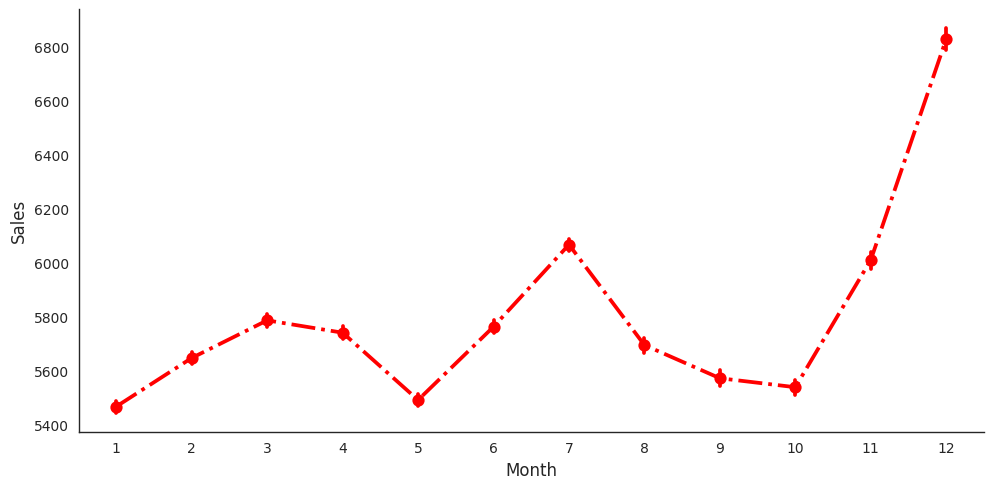

In [27]:
sns.catplot(x="Month" ,y = "Sales" , data=sales_data, kind="point", aspect=2,
            linestyles='dashdot',color="red")
plt.show()

In [28]:
# Value Counts of School_Holiday Column
sales_data.School_Holiday.value_counts()

School_Holiday
0    835488
1    181721
Name: count, dtype: int64

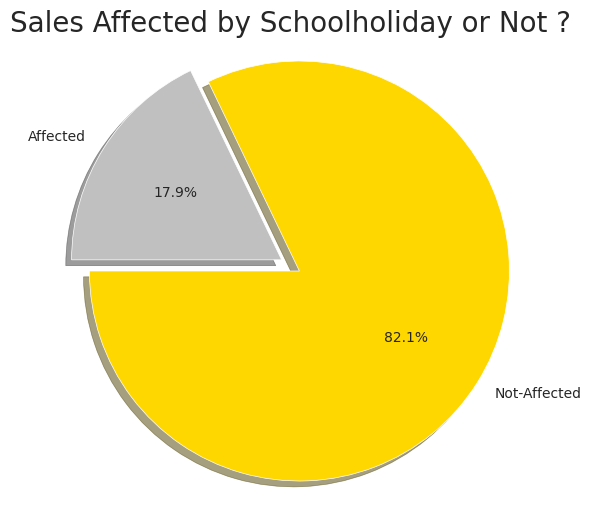

In [29]:
labels = 'Not-Affected' , 'Affected'
sizes = sales_data.School_Holiday.value_counts()
colors = ['gold', 'silver']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by Schoolholiday or Not ?",fontsize=20)
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()


As we can see in the Piechart Sales affected by School Holiday is 18% and Mainly Sales aren't afffected by School Holiday

In [30]:
# Transforming Variable State_Holiday
sales_data["State_Holiday"] = sales_data["State_Holiday"].map({0: 0, 1: 1, 2: 1, 3: 1})

In [31]:
sales_data.State_Holiday.value_counts()

State_Holiday
0    986159
1     31050
Name: count, dtype: int64

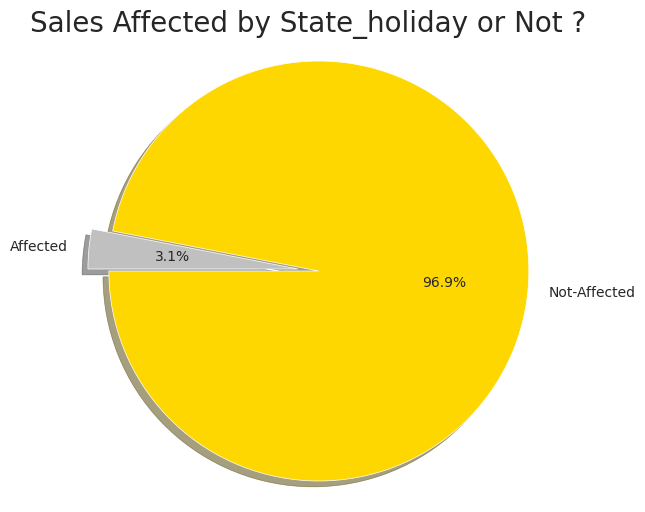

In [32]:
labels = 'Not-Affected' , 'Affected'
sizes = sales_data.State_Holiday.value_counts()
colors = ['gold', 'silver']
explode = (0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Sales Affected by State_holiday or Not ?",fontsize=20)
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

In [33]:
sales_data.drop('State_Holiday',inplace=True,axis=1)

# Analysing Store Dataset

In [34]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [35]:
store_data.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [36]:
store_data.rename(columns={'StoreType':'Store_Type','CompetitionDistance':'Competition_Distance',
                           'CompetitionOpenSinceMonth':'Competition_Open_Since_Month','CompetitionOpenSinceYear':'Competition_Open_Since_Year',
                           'Promo2':'Promo_2','Promo2SinceWeek':'Promo_2_Since_Week','Promo2SinceYear':'Promo_2_Since_Year','PromoInterval':'Promo_Interval'},inplace = True)

In [37]:
store_data.columns

Index(['Store', 'Store_Type', 'Assortment', 'Competition_Distance',
       'Competition_Open_Since_Month', 'Competition_Open_Since_Year',
       'Promo_2', 'Promo_2_Since_Week', 'Promo_2_Since_Year',
       'Promo_Interval'],
      dtype='object')

In [38]:
print("The Numbers of Rows (observation) is", store_data.shape[0],'\n',
      "The Numbers of Columns (variables) is", store_data.shape[1])

The Numbers of Rows (observation) is 1115 
 The Numbers of Columns (variables) is 10


In [39]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Store                         1115 non-null   int64  
 1   Store_Type                    1115 non-null   object 
 2   Assortment                    1115 non-null   object 
 3   Competition_Distance          1112 non-null   float64
 4   Competition_Open_Since_Month  761 non-null    float64
 5   Competition_Open_Since_Year   761 non-null    float64
 6   Promo_2                       1115 non-null   int64  
 7   Promo_2_Since_Week            571 non-null    float64
 8   Promo_2_Since_Year            571 non-null    float64
 9   Promo_Interval                571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [40]:
store_data.describe()

,Store,Competition_Distance,Competition_Open_Since_Month,Competition_Open_Since_Year,Promo_2,Promo_2_Since_Week,Promo_2_Since_Year
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [41]:
#Checking Null Values store_data
store_data.isnull().sum()

Store                             0
Store_Type                        0
Assortment                        0
Competition_Distance              3
Competition_Open_Since_Month    354
Competition_Open_Since_Year     354
Promo_2                           0
Promo_2_Since_Week              544
Promo_2_Since_Year              544
Promo_Interval                  544
dtype: int64

In [42]:
missing_percent = store_data.isnull().sum() / len(store_data) * 100
missing_percent

Store                            0.000000
Store_Type                       0.000000
Assortment                       0.000000
Competition_Distance             0.269058
Competition_Open_Since_Month    31.748879
Competition_Open_Since_Year     31.748879
Promo_2                          0.000000
Promo_2_Since_Week              48.789238
Promo_2_Since_Year              48.789238
Promo_Interval                  48.789238
dtype: float64

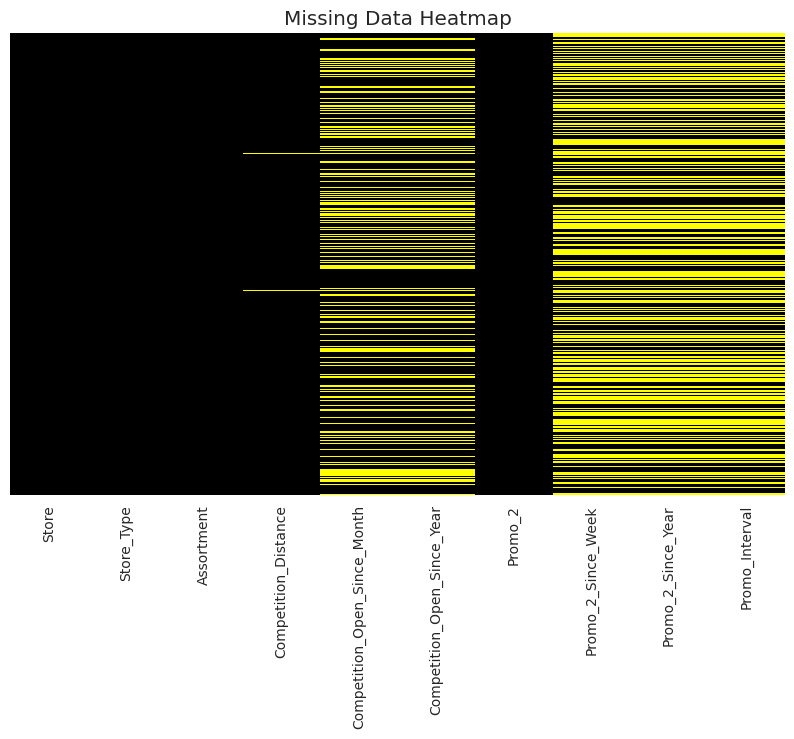

In [43]:
# creating heatmap for null values
plt.figure(figsize=(10,6))
sns.heatmap(store_data.isnull(),yticklabels= False, cbar= False, cmap= 'gnuplot')
plt.title('Missing Data Heatmap')
plt.show()

**Remove features with high percentages of missing values**
we can see that some features have a high percentage of missing values and they won't be accurate as indicators, so we will remove features with more than 30% missing values.

In [44]:
# remove features
store_data = store_data.drop(['Competition_Open_Since_Month', 'Competition_Open_Since_Year','Promo_2_Since_Week',
                     'Promo_2_Since_Year', 'Promo_Interval'], axis=1)

Replace missing values in features with low percentages of missing values

In [45]:
# replace missing values in Competition_Distance with median for the store dataset

store_data.Competition_Distance.fillna(store_data.Competition_Distance.median(), inplace=True)

In [46]:
store_data.head(2)

,Store,Store_Type,Assortment,Competition_Distance,Promo_2
0,1,c,a,1270.0,0
1,2,a,a,570.0,1


Distribution Of Different Store Types

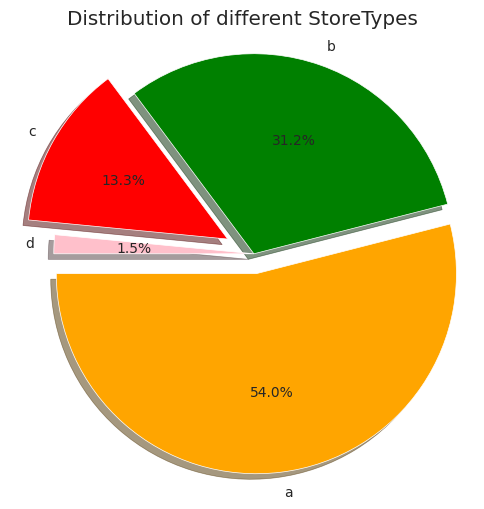

In [47]:
labels = 'a' , 'b' , 'c' , 'd'
sizes = store_data.Store_Type.value_counts()
colors = ['orange', 'green' , 'red' , 'pink']
explode = (0.1, 0.0 , 0.15 , 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.title("Distribution of different StoreTypes")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()


**Checking stores with their assortment type**

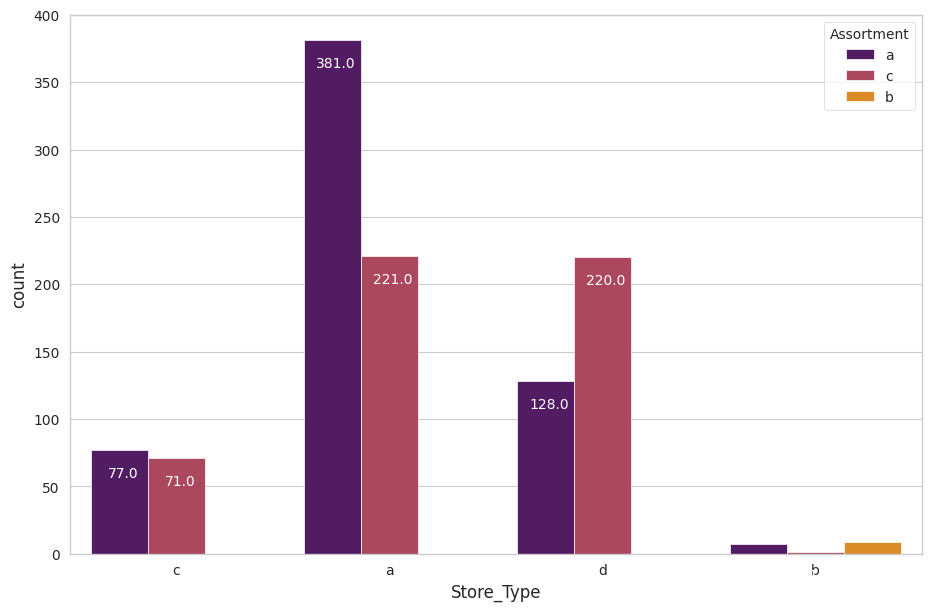

In [48]:
#checking stores with their assortment type
sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
Store_Type=sns.countplot(x='Store_Type',hue='Assortment', data=store_data,palette="inferno")

for p in Store_Type.patches:
    Store_Type.annotate(f'\n{p.get_height()}', (p.get_x()+0.15, p.get_height()),ha='center', va='top', color='white', size=10)

**We can see that there is not such significant differences in these 3 years in terms of sales**

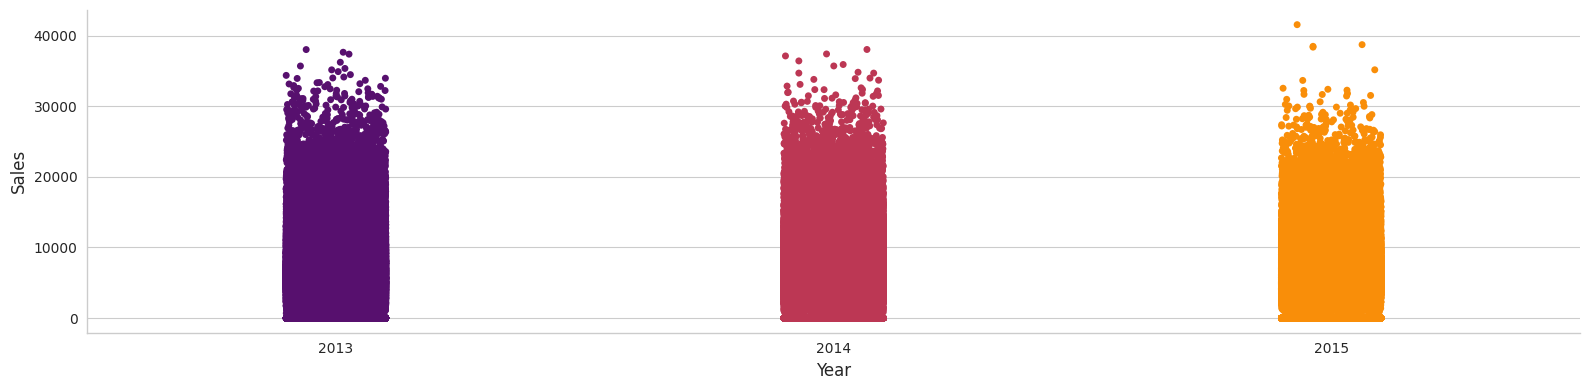

In [49]:
#plotting year vs sales
sns.catplot(x='Year',y='Sales',data=sales_data, height=4, aspect=4 , palette="inferno");

# Merging Two Datasets




In [50]:
df = pd.merge(sales_data, store_data, how='left', on='Store')
df.head()

,Store,Day_Of_Week,Date,Sales,Customers,Open,Promo,School_Holiday,Year,Month,Day,Week_Of_Year,Store_Type,Assortment,Competition_Distance,Promo_2
0,1,5,2015-07-31,5263,555,1,1,1,2015,7,31,31,c,a,1270.0,0
1,2,5,2015-07-31,6064,625,1,1,1,2015,7,31,31,a,a,570.0,1
2,3,5,2015-07-31,8314,821,1,1,1,2015,7,31,31,a,a,14130.0,1
3,4,5,2015-07-31,13995,1498,1,1,1,2015,7,31,31,c,c,620.0,0
4,5,5,2015-07-31,4822,559,1,1,1,2015,7,31,31,a,a,29910.0,0


In [51]:
df.columns

Index(['Store', 'Day_Of_Week', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'School_Holiday', 'Year', 'Month', 'Day', 'Week_Of_Year', 'Store_Type',
       'Assortment', 'Competition_Distance', 'Promo_2'],
      dtype='object')

In [52]:
print("The Numbers Of Rows (observation) is", df.shape[0],'\n',
      "The Numbers Of Columns (variables) is", df.shape[1])

The Numbers Of Rows (observation) is 1017209 
 The Numbers Of Columns (variables) is 16


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 16 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   Store                 1017209 non-null  int64         
 1   Day_Of_Week           1017209 non-null  int64         
 2   Date                  1017209 non-null  datetime64[ns]
 3   Sales                 1017209 non-null  int64         
 4   Customers             1017209 non-null  int64         
 5   Open                  1017209 non-null  int64         
 6   Promo                 1017209 non-null  int64         
 7   School_Holiday        1017209 non-null  int64         
 8   Year                  1017209 non-null  int64         
 9   Month                 1017209 non-null  int64         
 10  Day                   1017209 non-null  int64         
 11  Week_Of_Year          1017209 non-null  int64         
 12  Store_Type            1017209 non-null  ob

In [54]:
sales_data.describe()

,Store,Day_Of_Week,Date,Sales,Customers,Open,Promo,School_Holiday,Year,Month,Day,Week_Of_Year
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,2.013832e+03,5.846762e+00,1.570279e+01,2.361551e+01
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00,1.000000e+00,1.000000e+00
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,3.000000e+00,8.000000e+00,1.100000e+01
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.014000e+03,6.000000e+00,1.600000e+01,2.200000e+01
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,2.014000e+03,8.000000e+00,2.300000e+01,3.500000e+01
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,2.015000e+03,1.200000e+01,3.100000e+01,5.200000e+01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.773960e-01,3.326097e+00,8.787638e+00,1.443338e+01


In [55]:
# Checking Null Values Sales_data
sales_data.isnull().sum()

Store             0
Day_Of_Week       0
Date              0
Sales             0
Customers         0
Open              0
Promo             0
School_Holiday    0
Year              0
Month             0
Day               0
Week_Of_Year      0
dtype: int64

# EDA On Merged Dataset

Heatmap Of Merged Dataset

In [56]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[int, float])

In [57]:
# Compute correlation matrix
corr = numeric_df.corr().abs()

<Axes: >

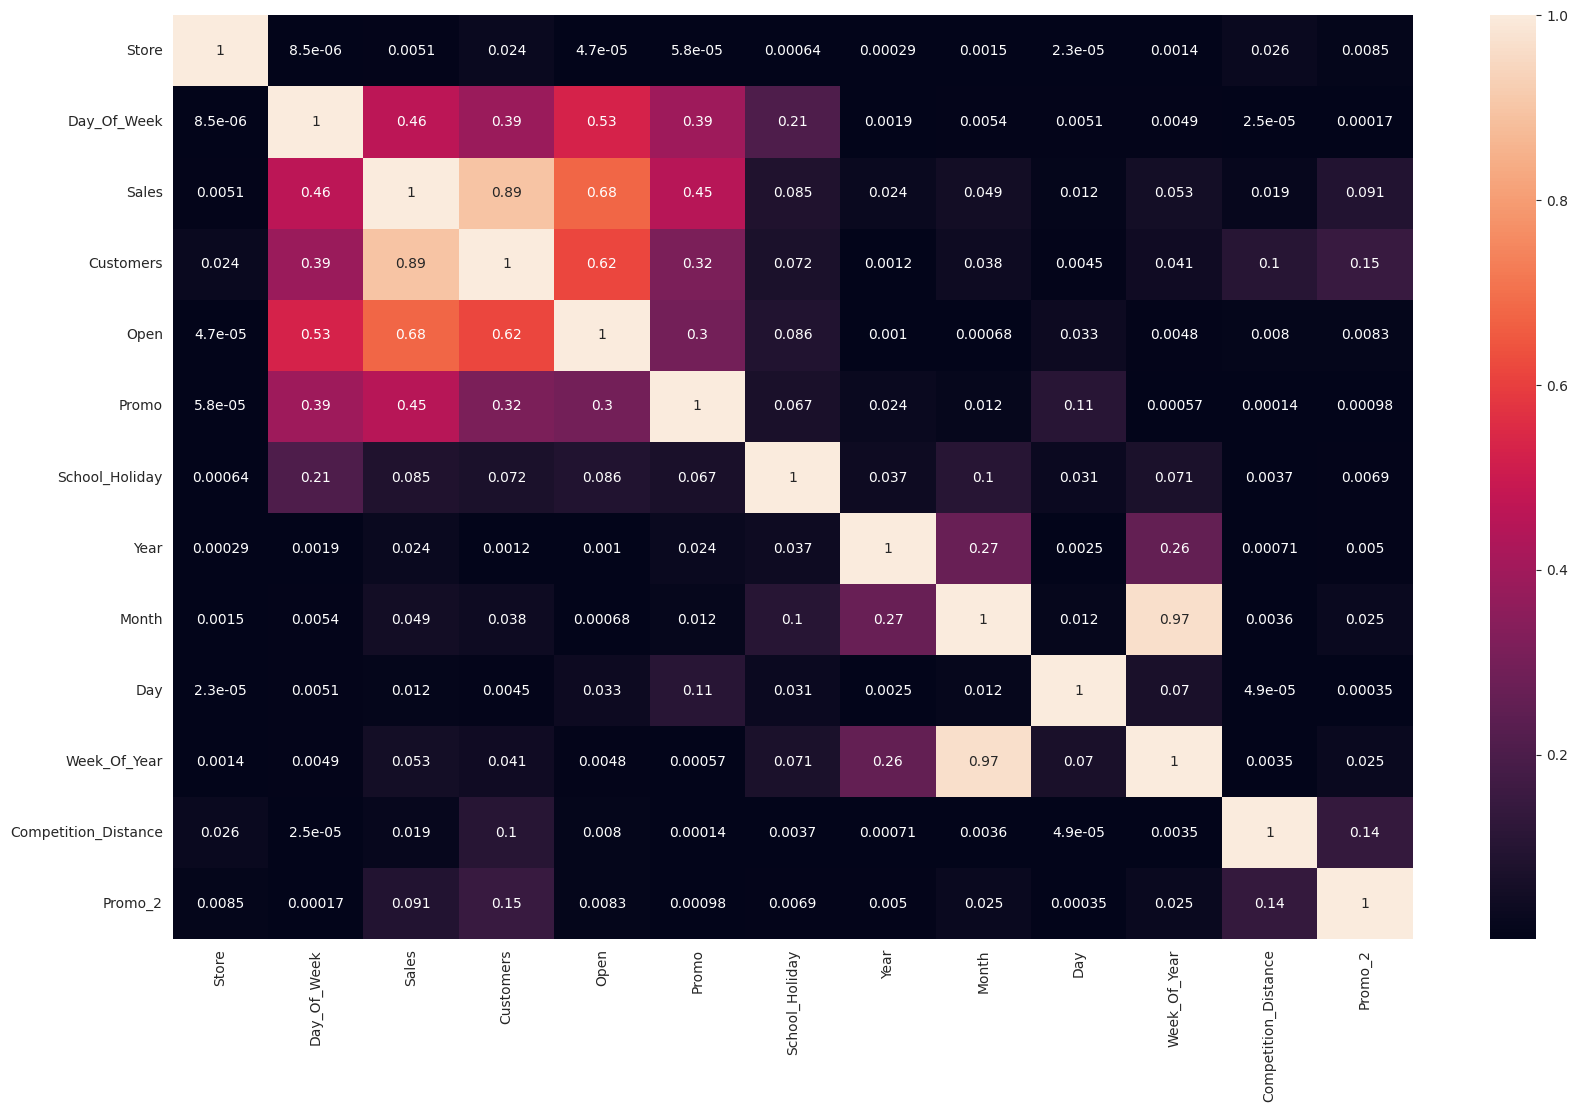

In [58]:
plt.subplots(figsize=(20,12))
sns.heatmap(corr.abs(), annot=True)

In [59]:
df["Avg_Customer_Sales"] = df.Sales/df.Customers
df.head(2)

,Store,Day_Of_Week,Date,Sales,Customers,Open,Promo,School_Holiday,Year,Month,Day,Week_Of_Year,Store_Type,Assortment,Competition_Distance,Promo_2,Avg_Customer_Sales
0,1,5,2015-07-31,5263,555,1,1,1,2015,7,31,31,c,a,1270.0,0,9.482883
1,2,5,2015-07-31,6064,625,1,1,1,2015,7,31,31,a,a,570.0,1,9.702400


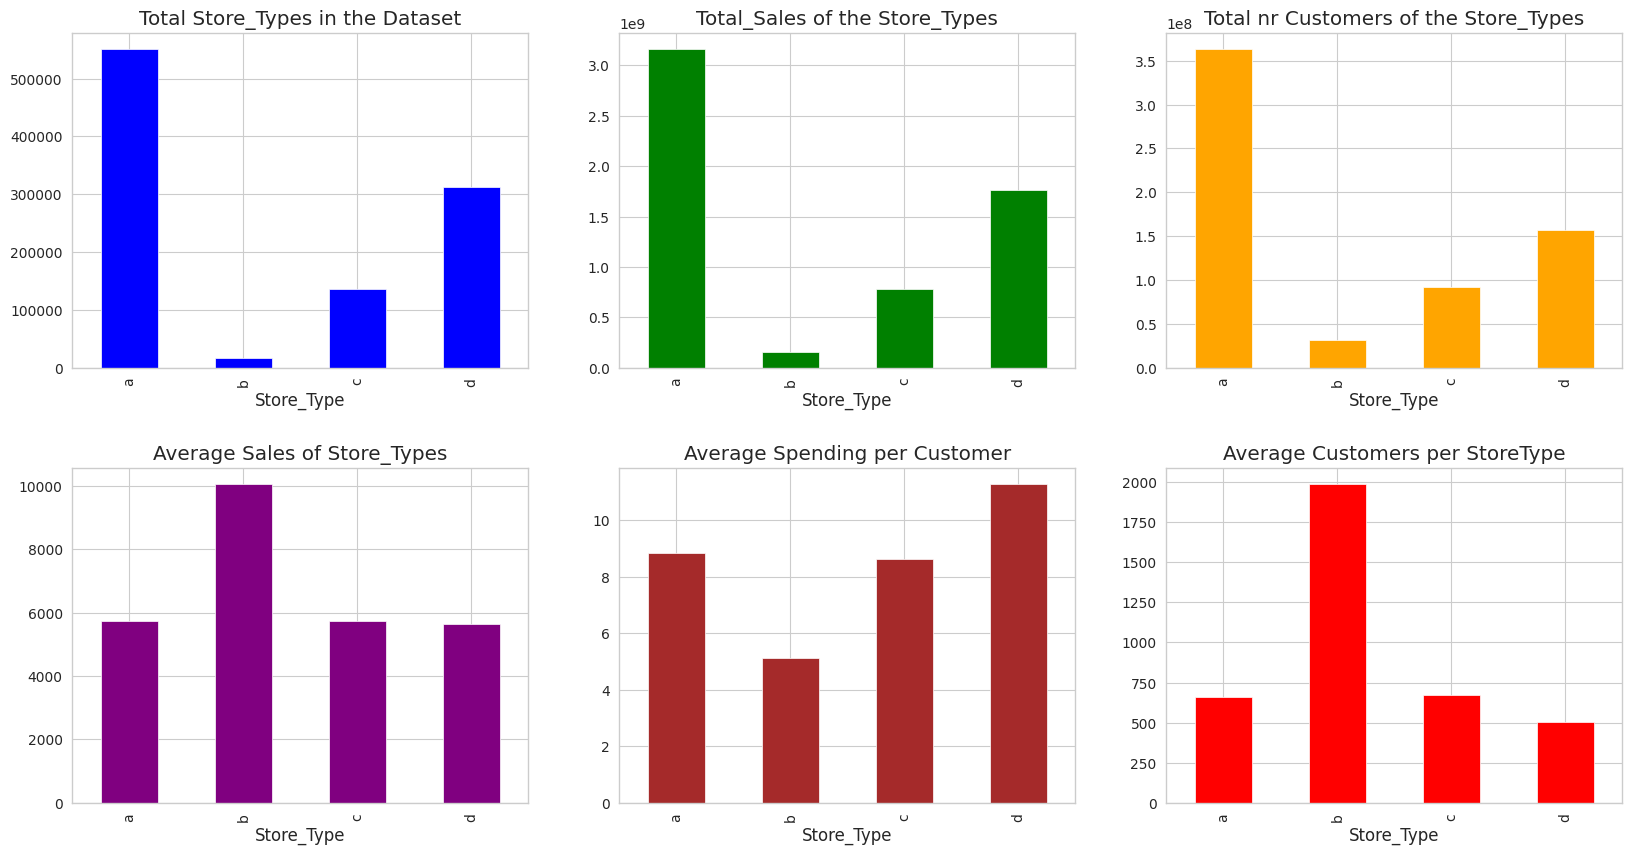

In [60]:
f, ax = plt.subplots(2, 3, figsize = (20,10))

df.groupby("Store_Type")["Store"].count().plot(kind = "bar", ax = ax[0, 0], title = "Total Store_Types in the Dataset",color='blue')
df.groupby("Store_Type")["Sales"].sum().plot(kind = "bar", ax = ax[0,1], title = "Total_Sales of the Store_Types", color='green')
df.groupby("Store_Type")["Customers"].sum().plot(kind = "bar", ax = ax[0,2], title = "Total nr Customers of the Store_Types",color='orange')
df.groupby("Store_Type")["Sales"].mean().plot(kind = "bar", ax = ax[1,0], title = "Average Sales of Store_Types", color='purple')
df.groupby("Store_Type")["Avg_Customer_Sales"].mean().plot(kind = "bar", ax = ax[1,1], title = "Average Spending per Customer", color='brown')
df.groupby("Store_Type")["Customers"].mean().plot(kind = "bar", ax = ax[1,2], title = "Average Customers per StoreType", color='red')

plt.subplots_adjust(hspace = 0.3)
plt.show()

As we can see from the graphs, the StoreType A has the most stores, sales and customers. However the StoreType D has the best averages spendings per customers. StoreType B, with only 17 stores has the most average customers.

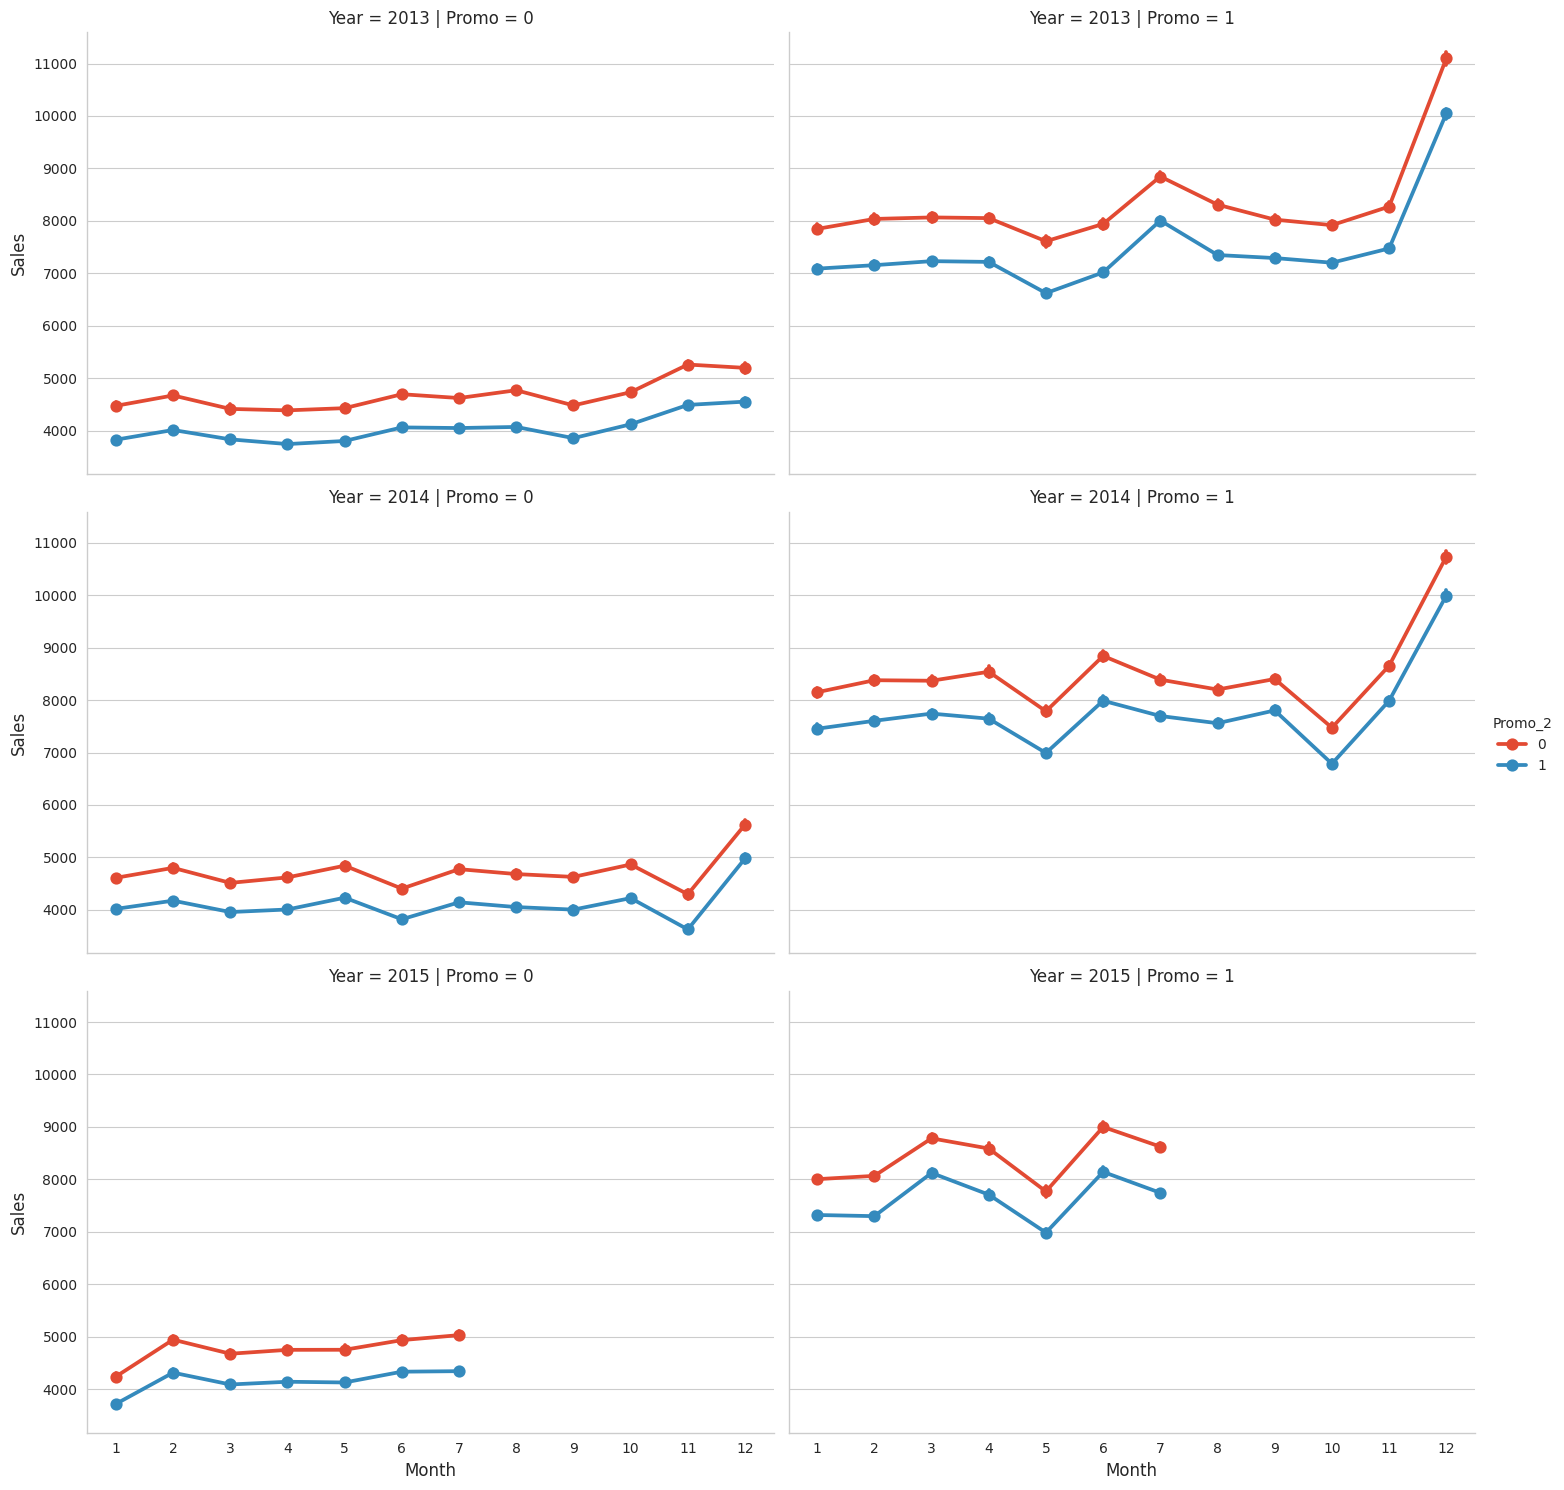

In [61]:
sns.catplot(data = df, x ="Month", y = "Sales",
               col = 'Promo', # per store type in cols
               hue = 'Promo_2',
               row = "Year",
               kind="point",
               aspect=1.5,
               height=5
            )

- So, of course, if the stores are having promotion the sells are higher.
- Overall the store promotions sellings are also higher than the seasionality promotions (Promo2). However I can't see no yearly trend.

As We can see that when the promo is running Sales are high

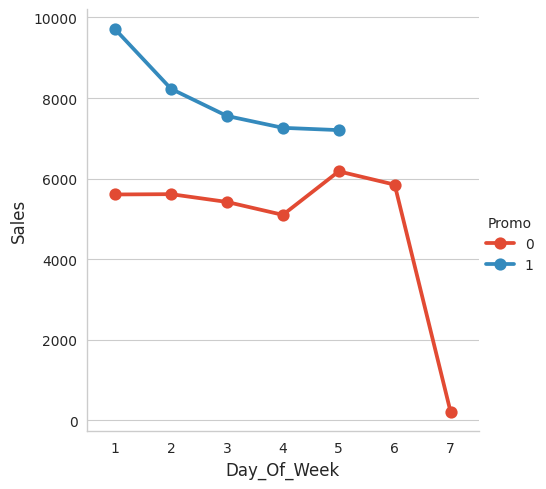

In [62]:
sns.catplot(data = df, x = "Day_Of_Week", y = "Sales", hue = "Promo",kind="point")

In [63]:
print("""So, no promotion in the weekend. However, the sales are very high, if the stores have promotion.
The Sales are going crazy on Sunday. No wonder.""")
print("There are", df[(df.Open == 1) & (df.Day_Of_Week == 7)].Store.unique().shape[0], "stores opend on sundays")

So, no promotion in the weekend. However, the sales are very high, if the stores have promotion.
The Sales are going crazy on Sunday. No wonder.
There are 33 stores opend on sundays


Let's see the trends on a yearly basis.

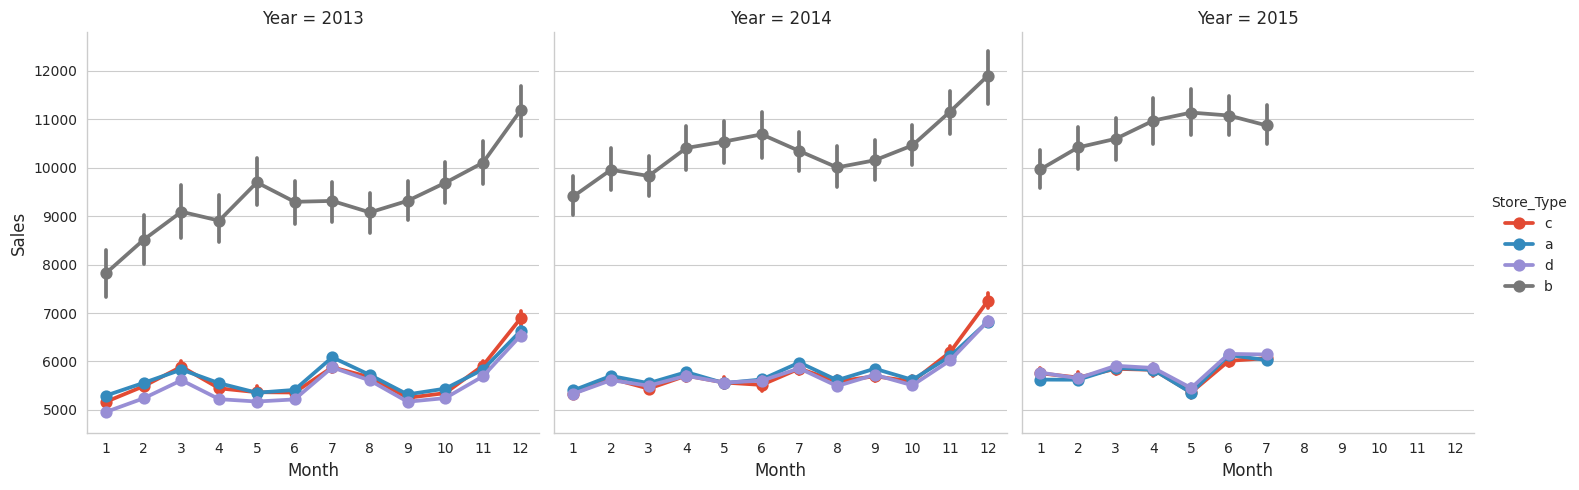

In [64]:
sns.catplot(data = df, x = "Month", y = "Sales", col = "Year", hue = "Store_Type", kind="point")

Yes, we can see a seasonalities, but not trends. The sales stays constantly yearly.

In [65]:
df.Competition_Distance.describe()

count    1.017209e+06
mean     5.422021e+03
std      7.706918e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.325000e+03
75%      6.880000e+03
max      7.586000e+04
Name: Competition_Distance, dtype: float64

In [66]:
# The obsverations are continous numbers, so we need to convert them into a categories. Lets a create a new variable.
df["Competition_Distance_Cat"] = pd.cut(df["Competition_Distance"],bins= 5)

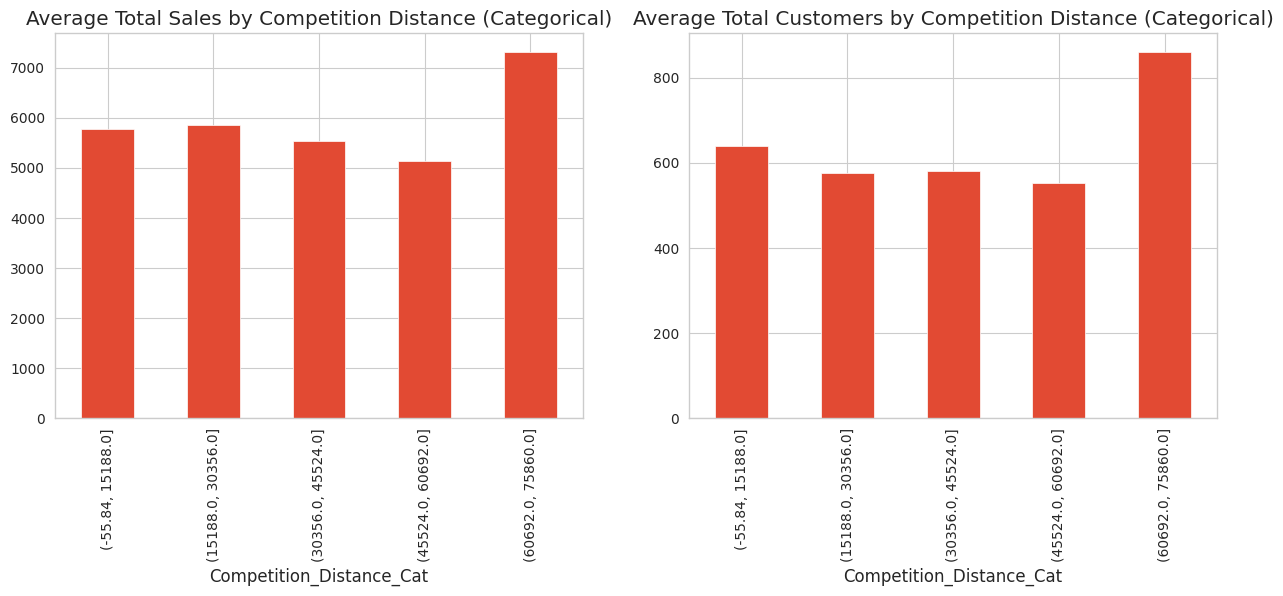

In [67]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
df.groupby("Competition_Distance_Cat")["Sales"].mean().plot(
    kind="bar", title="Average Total Sales by Competition Distance (Categorical)", ax=ax[0])
df.groupby("Competition_Distance_Cat")["Customers"].mean().plot(
    kind="bar", title="Average Total Customers by Competition Distance (Categorical)", ax=ax[1])

plt.show()

In [68]:
df.drop(['Avg_Customer_Sales','Competition_Distance_Cat'],axis=1,inplace=True)

# Conclusion of the analysis:

Sales are highly correlated to number of Customers
.

The most selling and crowded store type is A.

StoreType B has the lowest Average Sales per Customer. So i think customers visit this type only for small things.

StoreTybe D had the highest buyer cart.

Promo runs only in weekdays.

For all stores, Promotion leads to increase in Sales and Customers both.

More stores are opened during School holidays than State holidays.

The stores which are opened during School Holiday have more sales than normal days.

Sales are increased during Chirstmas week, this might be due to the fact that people buy more beauty products during a Christmas celebration.

Promo2 doesnt seems to be correlated to any significant change in the sales amount.

Absence of values in features CompetitionOpenSinceYear/Month doesn’t indicate the absence of competition as CompetitionDistance values are not null where the other two values are null.

# check outliers

<Axes: ylabel='Sales'>

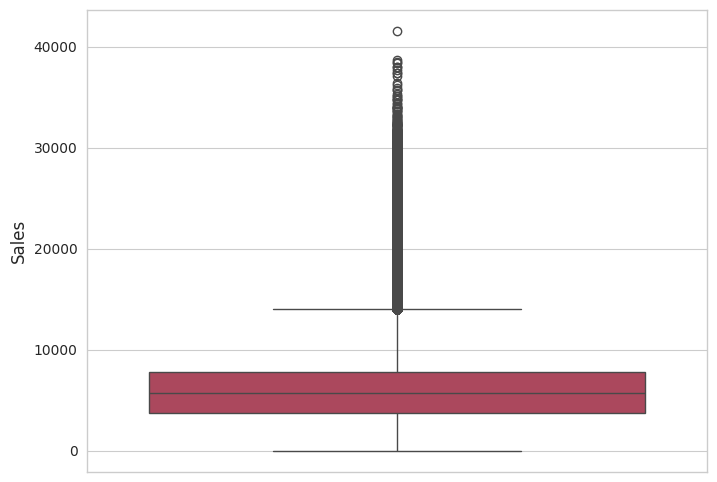

In [69]:
#checking outliers in sales
sns.boxplot(sales_data['Sales'],palette="inferno")

# Removing Outliers Of Sales Column

In [70]:
#removing outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [71]:
# defining new variable after removing outliers
df= remove_outlier(df, 'Sales')

# Drop Subsets Of Data Where Might Cause Bias

In [72]:
# where stores are closed, they won't generate sales, so we will remove that part of the dataset
df = df[df.Open != 0]
df.head(2)

,Store,Day_Of_Week,Date,Sales,Customers,Open,Promo,School_Holiday,Year,Month,Day,Week_Of_Year,Store_Type,Assortment,Competition_Distance,Promo_2
0,1,5,2015-07-31,5263,555,1,1,1,2015,7,31,31,c,a,1270.0,0
1,2,5,2015-07-31,6064,625,1,1,1,2015,7,31,31,a,a,570.0,1


In [73]:
df.Open.value_counts()

Open
1    817698
Name: count, dtype: int64

In [74]:
# Open isn't a variable anymore, so we'll drop it too
df = df.drop('Open', axis=1)

In [75]:
# Check if there's any opened store with zero sales
df[df.Sales == 0]['Store'].sum()

31460

In [76]:
# see the percentage of open stored with zero sales
df[df.Sales == 0]['Sales'].sum()/df.Sales.sum()

0.0

In [77]:
# remove this part of data to avoid bias
df = df[df.Sales != 0]

In [78]:
df_new=df.copy()

In [79]:
df_new = pd.get_dummies(df_new,columns=['Store_Type','Assortment'])
df_new.head()

,Store,Day_Of_Week,Date,Sales,Customers,Promo,School_Holiday,Year,Month,Day,Week_Of_Year,Competition_Distance,Promo_2,Store_Type_a,Store_Type_b,Store_Type_c,Store_Type_d,Assortment_a,Assortment_b,Assortment_c
0,1,5,2015-07-31,5263,555,1,1,2015,7,31,31,1270.0,0,False,False,True,False,True,False,False
1,2,5,2015-07-31,6064,625,1,1,2015,7,31,31,570.0,1,True,False,False,False,True,False,False
2,3,5,2015-07-31,8314,821,1,1,2015,7,31,31,14130.0,1,True,False,False,False,True,False,False
3,4,5,2015-07-31,13995,1498,1,1,2015,7,31,31,620.0,0,False,False,True,False,False,False,True
4,5,5,2015-07-31,4822,559,1,1,2015,7,31,31,29910.0,0,True,False,False,False,True,False,False


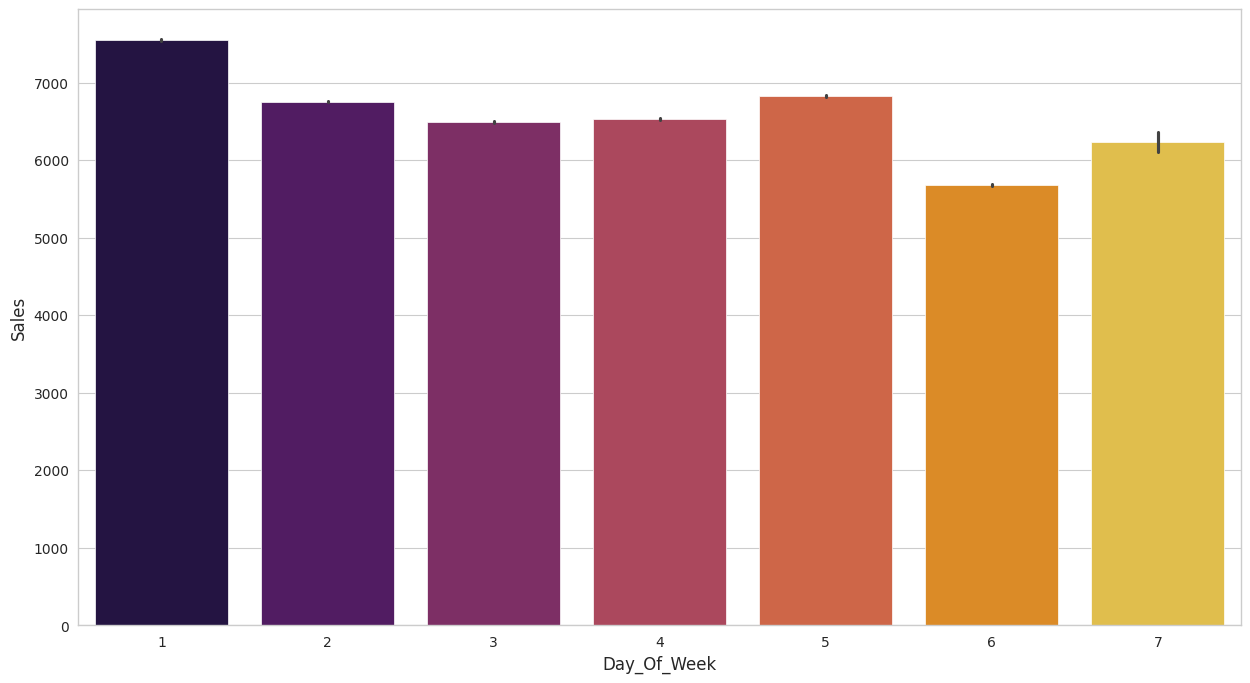

In [80]:
#plot for sales in terms of days of the week
plt.figure(figsize=(15,8))
sns.barplot(x='Day_Of_Week', y='Sales' ,data=df_new, palette="inferno");

From plot it can be sen that most of the sales have been on 1st and last day of week

# Setting Features and Target Variables

In [81]:
X = df_new.drop(['Sales','Store','Date','Year'] , axis = 1)
y= df_new.Sales

In [82]:
X.shape

(817644, 16)

In [83]:
X.head(2)

,Day_Of_Week,Customers,Promo,School_Holiday,Month,Day,Week_Of_Year,Competition_Distance,Promo_2,Store_Type_a,Store_Type_b,Store_Type_c,Store_Type_d,Assortment_a,Assortment_b,Assortment_c
0,5,555,1,1,7,31,31,1270.0,0,False,False,True,False,True,False,False
1,5,625,1,1,7,31,31,570.0,1,True,False,False,False,True,False,False


In [84]:
y.head(2)

0    5263
1    6064
Name: Sales, dtype: int64

# Splitting Dataset Into Training Set and Test Set

In [85]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=0)

In [86]:
columns=X_train.columns
columns

Index(['Day_Of_Week', 'Customers', 'Promo', 'School_Holiday', 'Month', 'Day',
       'Week_Of_Year', 'Competition_Distance', 'Promo_2', 'Store_Type_a',
       'Store_Type_b', 'Store_Type_c', 'Store_Type_d', 'Assortment_a',
       'Assortment_b', 'Assortment_c'],
      dtype='object')

# Implementing Supervised Machine Learning algorithms

# **Linear Regression (OLS)**

In [87]:
# Transforming data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [88]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [89]:
regressor.intercept_

-1507.441798569973

In [90]:
regressor.coef_

array([-1.30381346e+02,  3.06863041e+04,  1.09386001e+03,  2.29418388e+01,
        3.54223020e+02,  3.82831239e+01, -1.58021936e+02,  1.82430640e+03,
        3.10732033e+02,  3.18132398e+02, -1.90167603e+03,  1.67419398e+02,
        1.41612423e+03,  1.44688318e+03, -3.17950648e+03,  1.73262330e+03])

In [91]:
y_pred_train = regressor.predict(X_train)

In [92]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

In [93]:
mean_squared_error(y_test, y_pred)

1329406.2402058854

In [94]:
# Test performance
math.sqrt(mean_squared_error(y_test, y_pred))

1152.998803210951

In [95]:
train_score_1=regressor.score(X_train,y_train)
train_score_1

0.7807496727472854

In [96]:
test_score_1=regressor.score(X_test,y_test)
test_score_1

0.7823919595957616

In [97]:
#storing 100 observations for analysis
simple_lr_pred = y_pred[:100]
simple_lr_real = y_test[:100]
dataset_lr = pd.DataFrame({'Real':simple_lr_real,'PredictedLR':simple_lr_pred}) #storing these values into dataframe

In [98]:
#storing absolute diffrences between actual sales price and predicted
dataset_lr['diff']=(dataset_lr['Real']-dataset_lr['PredictedLR']).abs()

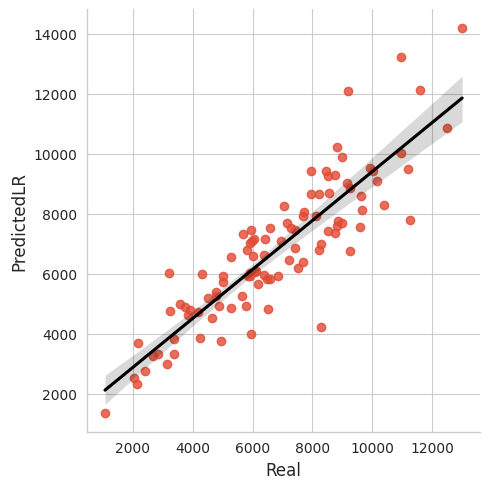

In [99]:
#visualising our predictions
sns.lmplot(x='Real', y='PredictedLR', data=dataset_lr, line_kws={'color': 'black'});

## Inferences On Linear Regression Coefficients

In [100]:
print(X.dtypes)

Day_Of_Week               int64
Customers                 int64
Promo                     int64
School_Holiday            int64
Month                     int64
Day                       int64
Week_Of_Year              int64
Competition_Distance    float64
Promo_2                   int64
Store_Type_a               bool
Store_Type_b               bool
Store_Type_c               bool
Store_Type_d               bool
Assortment_a               bool
Assortment_b               bool
Assortment_c               bool
dtype: object


In [101]:
# Convert boolean columns to integers
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

In [102]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                 2.086e+05
Date:                Sat, 15 Jun 2024   Prob (F-statistic):               0.00
Time:                        04:30:28   Log-Likelihood:            -6.9257e+06
No. Observations:              817644   AIC:                         1.385e+07
Df Residuals:                  817629   BIC:                         1.385e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -993.1075      5.669   -175.169      0.000   -1004.219    -981.996
Day_Of_Week            -21.0704      0.785    -26.837      0.000     -22.609     -19.532
Customers                7.2260      0.005   1471.966      0.000       7.216       7.236
Promo                 1093.4894      2.768    395.028      0.000    1088.064    1098.915
School_Holiday          27.2192      3.326      8.183      0.000      20.700      33.738
Month                   33.1415      1.433     23.134      0.000      30.334      35.949
Day                      1.2777      0.152      8.418      0.000       0.980       1.575
Week_Of_Year            -3.3867      0.330    -10.267      0.000      -4.033      -2.740
Competition_Distance     0.0240      0.000    140.522      0.000       0.024       0.024
Promo_2                307.7765      2.662    115.635      0.000     302.560     312.993
Store_Type_a            66.5792      4.780     13.929      0.000      57.211      75.948
Store_Type_b         -2140.7862     12.728   -168.195      0.000   -2165.733   -2115.840
Store_Type_c           -81.9285      5.313    -15.419      0.000     -92.342     -71.514
Store_Type_d          1163.0279      5.024    231.517      0.000    1153.182    1172.874
Assortment_a          1114.6637      6.456    172.654      0.000    1102.010    1127.317
Assortment_b         -3510.5496     15.385   -228.183      0.000   -3540.703   -3480.396
Assortment_c          1402.7783      6.642    211.194      0.000    1389.760    1415.797
==============================================================================
Omnibus:                    49108.747   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           145480.294
Skew:                           0.301   Prob(JB):                         0.00
Kurtosis:                       4.977   Cond. No.                     8.34e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.08e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

LARS Lasso Regression

In [103]:
las = LassoLars(alpha=0.3, fit_intercept=False, normalize=True)
lasreg = las.fit(X_train, y_train)

In [104]:
def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y):
    return np.mean(np.abs((x - y) / x)) * 100

train_score_2=lasreg.score(X_train, y_train)
test_score_2=lasreg.score(X_test, y_test)

print("Regresion Model Score" , ":" , train_score_2 , "," ,
      "Out of Sample Test Score" ,":" , test_score_2)

y_predicted = lasreg.predict(X_train)
y_test_predicted = lasreg.predict(X_test)

print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.7807308911324253 , Out of Sample Test Score : 0.7823685232825739
Training RMSE : 1155.0769465274698 Testing RMSE : 1153.0608903320883
Training MAPE : 14.215633319957128 Testing MAPE : 14.233294529232587


# Decision Tree Regression

In [105]:
tree = DecisionTreeRegressor()
treereg = tree.fit(X_train, y_train)

In [106]:
train_score_3=treereg.score(X_train, y_train)
test_score_3=treereg.score(X_test, y_test)

print("Regresion Model Score" , ":" , train_score_3 , "," ,
      "Test Score" ,":" , test_score_3)

y_predicted = treereg.predict(X_train)
y_test_predicted = treereg.predict(X_test)
print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.9999957301266714 , Test Score : 0.9157430923758036
Training RMSE : 5.097176662035323 Testing RMSE : 717.4541389025845
Training MAPE : 0.0010365300881590655 Testing MAPE : 7.642928094914721


# Decision Tree With Hyper Parameter Tuning

In [107]:
# #another script that takes toooo long, to find the right parameters for tree
# rfr=RandomForestRegressor(n_jobs=-1)
# tree = DecisionTreeRegressor()

# params = {
#          'min_samples_split':[2,3,5,7],
#          'min_samples_leaf':[6,8,10],
#          }

# grid = RandomizedSearchCV(estimator=rfr,param_distributions=params,verbose=True,cv=10)
# #choosing 10 K-Folds makes sure i went through all of the data and didn't miss any pattern.

# grid.fit(X_train, y_train)
# grid.best_params_

I trained Model with hyper parameters..to not run everytime i record the result

Here are our best parameters for Decision Tree

{ min_samples_split=5,min_samples_leaf=8 }

In [108]:
tree = DecisionTreeRegressor(min_samples_leaf=8,min_samples_split=5)
treereg = tree.fit(X_train, y_train)

In [109]:
train_score_4=treereg.score(X_train, y_train)
test_score_4=treereg.score(X_test, y_test)

print("Regresion Model Score" , ":" , train_score_4 , "," ,
      "Test Score" ,":" , test_score_4)

y_predicted = treereg.predict(X_train)
y_test_predicted = treereg.predict(X_test)
print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.9635058030756848 , Test Score : 0.9354004083849619
Training RMSE : 471.231263754792 Testing RMSE : 628.2120661746893
Training MAPE : 5.025365374933249 Testing MAPE : 6.691302200970141


In [110]:
#storing 100 observations for analysis
dc_pred = y_test_predicted[:100]
dc_real = y_test[:100]
dataset_dc = pd.DataFrame({'Real':dc_real,'PredictedDC':dc_pred}) #storing these values into dataframe

In [111]:
#storing absolute diffrences between actual sales price and predicted
dataset_dc['diff']=(dataset_dc['Real']-dataset_dc['PredictedDC']).abs()

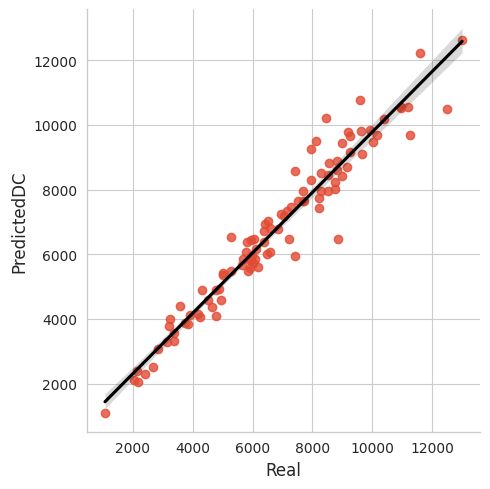

In [112]:
#visualising our predictions
sns.lmplot(x='Real', y='PredictedDC', data=dataset_dc, line_kws={'color': 'black'});

# RandomForest Classifier Model

In [113]:
# #another script that takes toooo long, to find the right parameters for RFR
# rfr=RandomForestRegressor(n_jobs=-1)

# params = {
#          'n_estimators':[40,50,60,70,80,90],
#          'min_samples_split':[2,3,6,8],
#          'min_samples_leaf':[1,2,3,4],
#          'max_depth':[None,5,15,30]
#          }

# #the dimensionality is high, the number of combinations we have to search is enormous, using RandomizedSearchCV is a better option then GridSearchCV
# grid = RandomizedSearchCV(estimator=rfr,param_distributions=params,verbose=True,cv=10)

# #choosing 10 K-Folds makes sure i went through all of the data and didn't miss any pattern.
# grid.fit(X_train, y_train)
# grid.best_params_

I trained Model with hyper parameters..to not run everytime i record the result

Here are our best parameters for Random Forest

{ n_estimators=80,min_samples_split=2,min_samples_leaf=1,max_depth=None }

In [114]:
#%%time
rdf = RandomForestRegressor(n_estimators=80,min_samples_split=2, min_samples_leaf=1,max_depth=None,n_jobs=-1)
rdfreg = rdf.fit(X_train, y_train)

In [115]:
train_score_5=rdfreg.score(X_train, y_train)
test_score_5=rdfreg.score(X_test, y_test)

print("Regresion Model Score" , ":" , train_score_5 , "," ,
      "Test Score" ,":" , test_score_5)

y_predicted_2 = rdfreg.predict(X_train)
y_test_predicted_2 = rdfreg.predict(X_test)

print("Training RMSE", ":", rmse(y_train, y_predicted_2),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted_2))
print("Training MAPE", ":", mape(y_train, y_predicted_2),
      "Testing MAPE", ":", mape(y_test, y_test_predicted_2))

Regresion Model Score : 0.9938117169626554 , Test Score : 0.9564335709935726
Training RMSE : 194.04715281228226 Testing RMSE : 515.9021874842367
Training MAPE : 2.1099350035174993 Testing MAPE : 5.660508925257605


In [116]:
y_test_predicted_2

array([8381.95  , 6134.475 , 8438.0875, ..., 6479.55  , 6179.5375,
       4566.275 ])

In [117]:
#storing 100 observations for analysis
rf_prd = y_test_predicted_2[:100]
rf_real = y_test[:100]
dataset_rf = pd.DataFrame({'Real':rf_real,'PredictedRF':rf_prd})

In [118]:
#storing absolute diffrences between actual sales price and predicted
dataset_rf['diff']=(dataset_rf['Real']-dataset_rf['PredictedRF']).abs()

In [119]:
 # taking 4 sample
dataset_rf.sample(4)

,Real,PredictedRF,diff
608959,3735,3884.2875,149.2875
591127,3376,3316.3500,59.6500
852282,7402,8291.9875,889.9875
31014,4789,4064.6000,724.4000


In [120]:
#Statistical description of our predictions and actual values
dataset_rf.describe()

,Real,PredictedRF,diff
count,100.000000,100.000000,100.000000
mean,6775.070000,6739.350250,379.812750
std,2534.335345,2441.263078,355.619616
min,1072.000000,1134.700000,18.112500
25%,5004.750000,5249.550000,130.328125
50%,6548.000000,6504.281250,287.068750
75%,8598.250000,8536.871875,483.975000
max,13001.000000,12611.412500,1965.987500


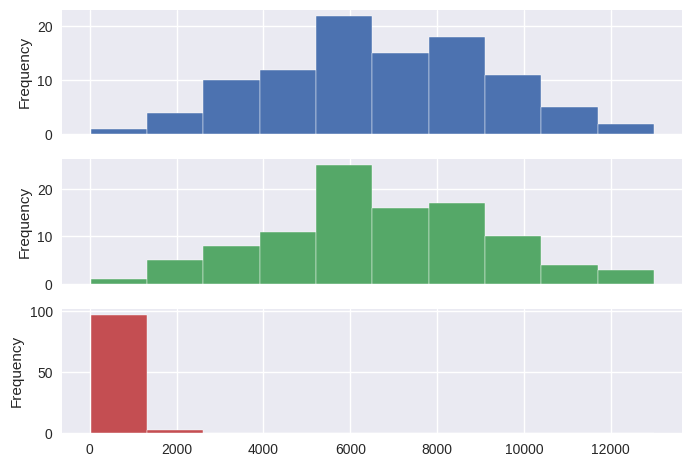

In [121]:
#plotting the actual,predicted & difference of SALES
plt.style.use('seaborn')
dataset_rf.plot.hist(subplots=True, legend=False);

As we can see that Actual, Prediction values are approximately closed to each other and there is no such significant variation in our plots.

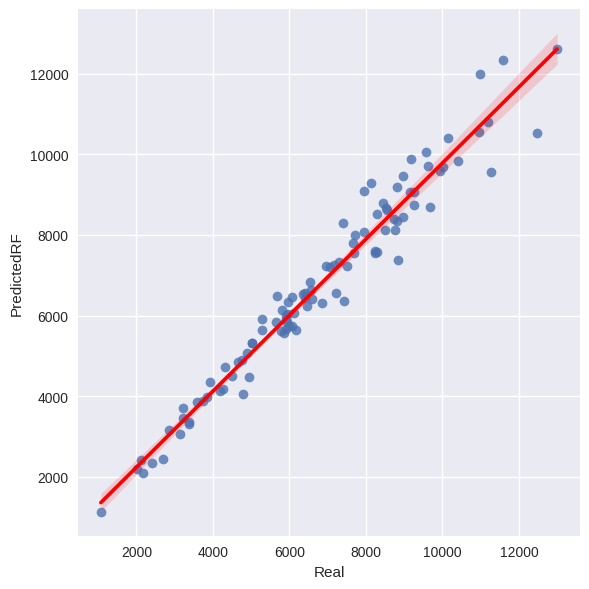

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming dataset_rf is your DataFrame containing 'Real' and 'PredictedRF' columns

# Visualizing the predictions with a linear model plot
sns.lmplot(x='Real', y='PredictedRF', data=dataset_rf, line_kws={'color': 'red'}, height=6, aspect=1)

# Display the plot
plt.show()

# Feature Importance On Random Forest Regressor

As we can see that Random Forest has the highest test score

In [123]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

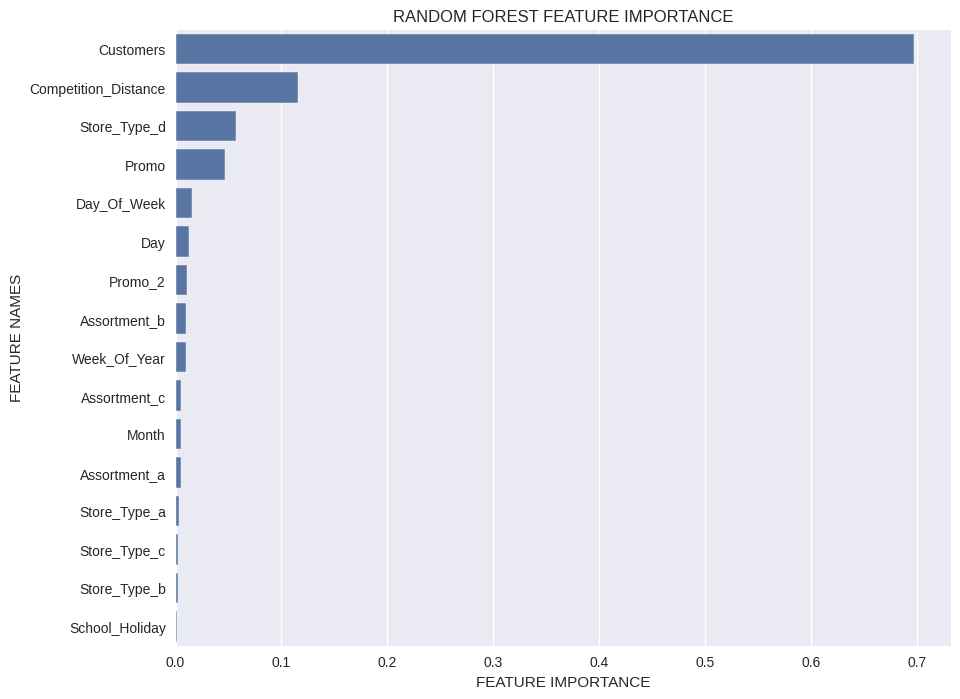

In [124]:
plot_feature_importance(rdfreg.feature_importances_,columns[:],'RANDOM FOREST')

Customers, CompetitionDistance, StoreType_d, Promo these four are most important features in our sales prediction.

In [125]:
score_df = pd.DataFrame({'Train_Score':[train_score_1,train_score_2,train_score_3,train_score_4,train_score_5],'Test_Score':[test_score_1,test_score_2,test_score_3,test_score_4,test_score_5]},index=['Linear Regression','Lasso Regression','Decision Tree',"Decision Tree(hyperparameters)",'Random Forest Regression'])

# Conclusion

In [126]:
score_df

,Train_Score,Test_Score
Linear Regression,0.780750,0.782392
Lasso Regression,0.780731,0.782369
Decision Tree,0.999996,0.915743
Decision Tree(hyperparameters),0.963506,0.935400
Random Forest Regression,0.993812,0.956434
